In [4]:
import os
import shutil
import splitfolders
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import imghdr
import numpy as np
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
# FIXED: Use the correct IPython import path
from IPython import get_ipython

# --- CONFIGURATION ---
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
# Use get_ipython() to call the magic command
if get_ipython() is not None:
    get_ipython().run_line_magic('env', 'TF_CPP_MIN_LOG_LEVEL=2') # Suppress TF warnings

# Define file paths
ZIP_FILE_PATH = '/content/drive/MyDrive/archive.zip'
RAW_DATA_DIR = '/content/garbage_data_raw'
FLAT_DATA_DIR = '/content/garbage_data_flat_final'
OUTPUT_SPLIT_DIR = '/content/garbage_data_split_final'
LOG_DIR = '/content/logs'

# Define Partition Structure (for documentation and class list)
PARTITIONS = {
    "P1_Consumer_Waste": ["paper", "glass"],
    "P2_Shop_Waste": ["cardboard", "clothes", "metal", "plastic"],
    "P3_Food_Waste": ["biological"],
    "P4_Extra_Waste": ["battery", "shoes"]
}
CLASSES_TO_PROCESS = sum(PARTITIONS.values(), [])

# --- STEP 1: INSTALL AND MOUNT ---
print("--- STEP 1: INSTALL AND MOUNT ---")
# Use -q for quiet installation
!pip install split-folders codecarbon -q
print("Mounting Google Drive...")
# Force remount to ensure clean access
drive.mount('/content/drive', force_remount=True)
print("Drive mounted.")

# --- STEP 2: EXTRACT DATA ---
print("\n--- STEP 2: EXTRACT DATA ---")
if os.path.exists(RAW_DATA_DIR):
    shutil.rmtree(RAW_DATA_DIR)
os.makedirs(RAW_DATA_DIR, exist_ok=True)

try:
    # Extract to RAW_DATA_DIR
    !unzip -q "$ZIP_FILE_PATH" -d "$RAW_DATA_DIR"
    # Assume the extracted folder is named 'garbage-dataset'
    BASE_DATA_PATH = os.path.join(RAW_DATA_DIR, 'garbage-dataset')

    if not os.path.exists(BASE_DATA_PATH) or not os.listdir(BASE_DATA_PATH):
        # Fallback if 'garbage-dataset' wasn't the container folder
        print("Warning: 'garbage-dataset' not found. Checking root extraction directory.")
        BASE_DATA_PATH = RAW_DATA_DIR

    # Final check for the data location
    if not os.path.exists(os.path.join(BASE_DATA_PATH, CLASSES_TO_PROCESS[0])):
        print("FATAL ERROR: Could not locate class folders. Check ZIP structure.")
        # Attempt to find the correct deep path if a subfolder exists
        subdirs = [d for d in os.listdir(BASE_DATA_PATH) if os.path.isdir(os.path.join(BASE_DATA_PATH, d))]
        if subdirs and os.path.isdir(os.path.join(BASE_DATA_PATH, subdirs[0], CLASSES_TO_PROCESS[0])):
             BASE_DATA_PATH = os.path.join(BASE_DATA_PATH, subdirs[0])
             print(f"Path fixed: Data found at {BASE_DATA_PATH}")

    print(f"Data extracted successfully. Base data path: {BASE_DATA_PATH}")

except Exception as e:
    print(f"FATAL ERROR during extraction: {e}")
    raise FileNotFoundError("Extraction failed. Check archive.zip path.")


# --- STEP 3: CLEANING AND FLATTENING (Removing 'trash' and corrupt files) ---
print("\n--- STEP 3: CLEANING AND FLATTENING ---")
if os.path.exists(FLAT_DATA_DIR):
    shutil.rmtree(FLAT_DATA_DIR)
os.makedirs(FLAT_DATA_DIR, exist_ok=True)
if os.path.exists(OUTPUT_SPLIT_DIR):
    shutil.rmtree(OUTPUT_SPLIT_DIR)

# Function to copy files while checking integrity
def clean_and_copy_class(class_name, source_base, target_base):
    source_class_dir = os.path.join(source_base, class_name)
    target_class_dir = os.path.join(target_base, class_name)
    removed_count = 0

    if os.path.isdir(source_class_dir):
        os.makedirs(target_class_dir, exist_ok=True)
        img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

        for filepath in Path(source_class_dir).rglob("*"):
            if filepath.is_file():
                img_type = imghdr.what(filepath)

                if img_type is not None and img_type in img_type_accepted_by_tf:
                    try:
                        shutil.copy(str(filepath), target_class_dir)
                    except Exception:
                        removed_count += 1
                else:
                    removed_count += 1

    return removed_count

total_removed = 0
for class_name in CLASSES_TO_PROCESS:
    total_removed += clean_and_copy_class(class_name, BASE_DATA_PATH, FLAT_DATA_DIR)

print(f"Structure flattened. 9 class folders copied to: {FLAT_DATA_DIR}")
print(f"Total corrupted/unsupported files ignored/removed: {total_removed}")

# --- STEP 4: VERIFICATION AND SPLIT ---
print("\n--- STEP 4: VERIFICATION AND SPLIT (80/10/10) ---")
flat_contents = [name for name in os.listdir(FLAT_DATA_DIR) if os.path.isdir(os.path.join(FLAT_DATA_DIR, name))]
print(f"Verification: {len(flat_contents)} class folders found: {flat_contents}")

if len(flat_contents) != 9:
    raise FileNotFoundError("FATAL: Not all 9 class folders were found in the flat directory.")

splitfolders.ratio(
    FLAT_DATA_DIR,
    output=OUTPUT_SPLIT_DIR,
    seed=SEED,
    ratio=(.8, .1, .1),
    group_prefix=None
)
print(f"Data split complete. Split data available in {OUTPUT_SPLIT_DIR}/{{train,val,test}}.")

# --- STEP 5: COUNT AND VISUALIZE ---
train_path = os.path.join(OUTPUT_SPLIT_DIR, 'train')
val_path = os.path.join(OUTPUT_SPLIT_DIR, 'val')
test_path = os.path.join(OUTPUT_SPLIT_DIR, 'test')

class_counts = {}
total_images_train = 0

for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        count = len(os.listdir(class_dir))
        class_counts[class_name] = count
        total_images_train += count

print(f"\nTotal training images across all classes: {total_images_train}")
print("\n--- Training Data Class Distribution (9 Categories) ---")

df_counts = pd.DataFrame(
    list(class_counts.items()),
    columns=['Class Name', 'Count']
).sort_values(by='Count', ascending=False)

# Print the final data table
print(df_counts.to_markdown(index=False))

# Plot the distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Class Name', y='Count', data=df_counts, palette='viridis')
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Training Data Distribution by Individual Waste Category')
plt.tight_layout()
plt.show()

# Store paths and data for the next shell
if get_ipython() is not None:
    get_ipython().run_line_magic('store', 'train_path')
    get_ipython().run_line_magic('store', 'val_path')
    get_ipython().run_line_magic('store', 'test_path')
    get_ipython().run_line_magic('store', 'df_counts')
    get_ipython().run_line_magic('store', 'PARTITIONS')
    get_ipython().run_line_magic('store', 'CLASSES_TO_PROCESS')

print("\n🎉 ALL DATA PREP COMPLETE. Ready for MobileNet Model Setup (Shell 5).")

ModuleNotFoundError: No module named 'splitfolders'

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from IPython import get_ipython
from datetime import datetime
import pandas as pd

# The 'model', 'train_generator', and 'validation_generator' objects
# are expected to be available in the current runtime environment from Shell 5.

# --- CONFIGURATION ---
NUM_EPOCHS = 15
MODEL_SAVE_DIR = '/content/drive/MyDrive/Garbage_Model_Output'
LOG_DIR = '/content/logs/fit'
MODEL_FILENAME = 'best_mobilenet_model.h5'

# Make sure the save directory exists
if not os.path.exists(MODEL_SAVE_DIR):
    os.makedirs(MODEL_SAVE_DIR)

# --- 1. Define Callbacks ---
print("--- 1. Defining Callbacks ---")

# Early Stopping: Stop training if validation loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpointing: Save the model weights only when validation accuracy improves
# This ensures we always keep the best performing model.
checkpoint_filepath = os.path.join(MODEL_SAVE_DIR, MODEL_FILENAME)
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# TensorBoard: Log metrics for visualization
tensorboard_callback = TensorBoard(
    log_dir=os.path.join(LOG_DIR, datetime.now().strftime("%Y%m%d-%H%M%S"))
)

# --- 2. Model Training ---
print("\n--- 2. Starting Model Training ---")

# We rely on the objects being in memory from the successful part of Shell 5's execution.
# If this fails, the notebook must be restarted from Shell 5 and run until the end.
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping, model_checkpoint, tensorboard_callback]
    )
except NameError as e:
    print(f"\nFATAL ERROR: A required object (model, train_generator, or validation_generator) is missing from memory: {e}. Please re-run Shell 5 completely and then run Shell 6.")
    raise

# --- 3. Save Final Model and History ---
print("\n--- 3. Saving Final Results ---")

# Save the training history for later plotting
history_path = os.path.join(MODEL_SAVE_DIR, 'training_history.csv')
pd.DataFrame(history.history).to_csv(history_path, index=False)

print(f"Best model saved to Google Drive: {checkpoint_filepath}")
print(f"Training history saved to Google Drive: {history_path}")

print("\nShell 6 complete. Training finished.")

--- 1. Defining Callbacks ---

--- 2. Starting Model Training ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.6301 - loss: 1.1347
Epoch 1: val_accuracy improved from -inf to 0.89547, saving model to /content/drive/MyDrive/Garbage_Model_Output/best_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 242s 474ms/step - accuracy: 0.6304 - loss: 1.1338 - val_accuracy: 0.8955 - val_loss: 0.3234
Epoch 2/15
  1/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9375 - loss: 0.3387

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.89547 to 0.89655, saving model to /content/drive/MyDrive/Garbage_Model_Output/best_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9375 - loss: 0.3387 - val_accuracy: 0.8966 - val_loss: 0.3232
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8689 - loss: 0.4052
Epoch 3: val_accuracy improved from 0.89655 to 0.91164, saving model to /content/drive/MyDrive/Garbage_Model_Output/best_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 223s 434ms/step - accuracy: 0.8689 - loss: 0.4051 - val_accuracy: 0.9116 - val_loss: 0.2710
Epoch 4/15
  1/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.8750 - loss: 0.4228
Epoch 4: val_accuracy did not improve from 0.91164
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8750 - loss: 0.4228 - val_accuracy: 0.9116 - val_loss: 0.2710
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8911 - loss: 0.3385
Epoch 5: val_accuracy improved from 0.91164 to 0.91595, saving model to /content/drive/MyDrive/Garbage_Model_Output/best_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 434ms/step - accuracy: 0.8911 - loss: 0.3385 - val_accuracy: 0.9159 - val_loss: 0.2508
Epoch 6/15
  1/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.9062 - loss: 0.2354
Epoch 6: val_accuracy improved from 0.91595 to 0.91649, saving model to /content/drive/MyDrive/Garbage_Model_Output/best_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9062 - loss: 0.2354 - val_accuracy: 0.9165 - val_loss: 0.2513
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9034 - loss: 0.2881
Epoch 7: val_accuracy improved from 0.91649 to 0.91756, saving model to /content/drive/MyDrive/Garbage_Model_Output/best_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 209s 446ms/step - accuracy: 0.9034 - loss: 0.2881 - val_accuracy: 0.9176 - val_loss: 0.2338
Epoch 8/15
  1/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9375 - loss: 0.2752
Epoch 8: val_accuracy improved from 0.91756 to 0.91864, saving model to /content/drive/MyDrive/Garbage_Model_Output/best_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9375 - loss: 0.2752 - val_accuracy: 0.9186 - val_loss: 0.2338
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9097 - loss: 0.2740
Epoch 9: val_accuracy improved from 0.91864 to 0.92080, saving model to /content/drive/MyDrive/Garbage_Model_Output/best_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 430ms/step - accuracy: 0.9097 - loss: 0.2740 - val_accuracy: 0.9208 - val_loss: 0.2255
Epoch 10/15
  1/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.9688 - loss: 0.2485
Epoch 10: val_accuracy did not improve from 0.92080
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9688 - loss: 0.2485 - val_accuracy: 0.9203 - val_loss: 0.2262
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9153 - loss: 0.2493
Epoch 11: val_accuracy improved from 0.92080 to 0.92619, saving model to /content/drive/MyDrive/Garbage_Model_Output/best_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 431ms/step - accuracy: 0.9153 - loss: 0.2493 - val_accuracy: 0.9262 - val_loss: 0.2151
Epoch 12/15
  1/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.8750 - loss: 0.1981
Epoch 12: val_accuracy did not improve from 0.92619
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8750 - loss: 0.1981 - val_accuracy: 0.9262 - val_loss: 0.2151
Epoch 13/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9190 - loss: 0.2425
Epoch 13: val_accuracy did not improve from 0.92619
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 430ms/step - accuracy: 0.9190 - loss: 0.2425 - val_accuracy: 0.9219 - val_loss: 0.2201
Epoch 14/15
  1/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9062 - loss: 0.2634
Epoch 14: val_accuracy did not improve from 0.92619
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9062 - loss: 0.2634 - val_accuracy: 0.9213 - val_loss: 0.2208
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 11.

--- 3. Saving

--- 1. Loading Best Model and Training History ---


Model loaded successfully from: /content/drive/MyDrive/Garbage_Model_Output/best_mobilenet_model.h5
History loaded successfully from: /content/drive/MyDrive/Garbage_Model_Output/training_history.csv

--- 2. Preparing Test Data Generator ---
Found 1887 images belonging to 9 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



--- 3. Evaluating Model on Unseen Test Data ---
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.9525 - loss: 0.1781

✅ Test Set Evaluation Results:
   Test Loss: 0.1731
   Test Accuracy: 0.9520

--- 4. Generating Classification Report and Confusion Matrix ---
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 181ms/step

--- Classification Report ---
              precision    recall  f1-score   support

     battery       1.00      0.92      0.96        95
  biological       0.99      0.95      0.97       101
   cardboard       0.95      0.94      0.95       183
     clothes       0.99      0.99      0.99       534
       glass       0.95      0.93      0.94       307
       metal       0.82      0.96      0.88       102
       paper       0.92      0.95      0.94       168
     plastic       0.91      0.90      0.91       198
       shoes       0.96      0.98      0.97       199

    accuracy                           0.95      1887
   macro avg       0.94      0.95      0.94      1887
weighted 

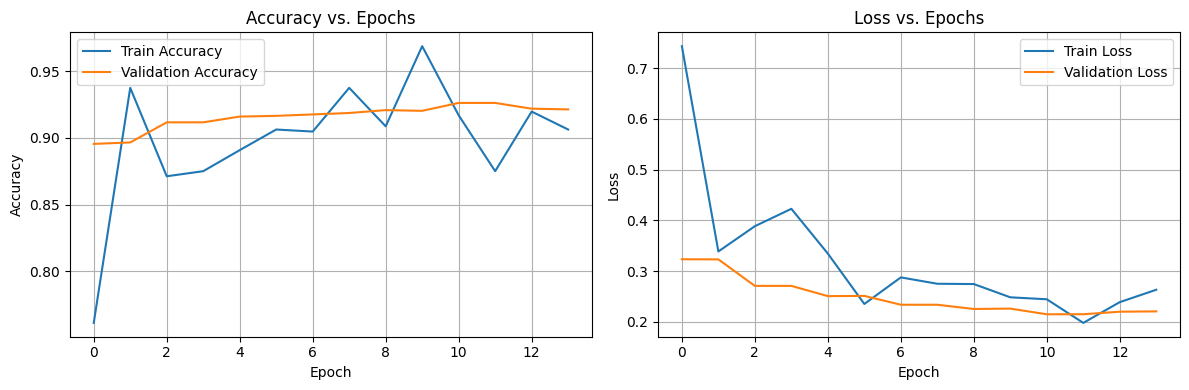


--- 6. Storing variables for Shell 8 ---
Stored 'train_path' (str)
Stored 'val_path' (str)
Stored 'test_path' (str)
Stored 'class_labels' (list)

Shell 7 complete. Evaluation finished and variables stored for Shell 8.


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from IPython import get_ipython

# Load previously stored variables (Need train_path, val_path, test_path, and CLASSES_TO_PROCESS)
if get_ipython() is not None:
    get_ipython().run_line_magic('store', '-r test_path train_path val_path CLASSES_TO_PROCESS')

# --- CONFIGURATION ---
IMG_SIZE = 224
BATCH_SIZE = 32
MODEL_SAVE_DIR = '/content/drive/MyDrive/Garbage_Model_Output'
MODEL_FILENAME = 'best_mobilenet_model.h5'
checkpoint_filepath = os.path.join(MODEL_SAVE_DIR, MODEL_FILENAME)
history_path = os.path.join(MODEL_SAVE_DIR, 'training_history.csv')

# --- 1. Load Best Model and History ---
print("--- 1. Loading Best Model and Training History ---")
# Reload the best model saved by the checkpoint callback
try:
    best_model = load_model(checkpoint_filepath)
    print(f"Model loaded successfully from: {checkpoint_filepath}")
except Exception as e:
    print(f"FATAL ERROR: Could not load model. Ensure your Drive is mounted and the file exists. Error: {e}")
    raise

history_df = pd.read_csv(history_path)
print(f"History loaded successfully from: {history_path}")

# --- 2. Setup Test Data Generator ---
print("\n--- 2. Preparing Test Data Generator ---")
# MobileNetV2 requires the same preprocessing function
mobilenet_preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create the Test Generator (NO augmentation, NO shuffling)
test_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Crucial for evaluation and reporting
)
test_steps = test_generator.samples // test_generator.batch_size

# --- 3. Evaluate Model on Test Set ---
print("\n--- 3. Evaluating Model on Unseen Test Data ---")
loss, accuracy = best_model.evaluate(test_generator, steps=test_steps, verbose=1)

print(f"\n✅ Test Set Evaluation Results:")
print(f"   Test Loss: {loss:.4f}")
print(f"   Test Accuracy: {accuracy:.4f}")

# --- 4. Detailed Performance Analysis ---
print("\n--- 4. Generating Classification Report and Confusion Matrix ---")
# Predict probabilities on the test set
# Add 1 step to cover any remaining samples not covered by the integer division
Y_pred = best_model.predict(test_generator, steps=test_steps + 1)
# Convert predictions from probabilities to class indices
y_pred_classes = np.argmax(Y_pred, axis=1)

# Get true labels corresponding to the samples predicted
# We must truncate y_true to match the number of samples predicted by the generator
y_true = test_generator.classes[:len(y_pred_classes)]

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Print Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# --- 5. Visualize Training History ---
print("\n--- 5. Visualizing Training History ---")

plt.figure(figsize=(12, 4))
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 6. Prepare for Fine-Tuning (Next Shell) ---
print("\n--- 6. Storing variables for Shell 8 ---")
# FIXED: Only store simple, pickle-able data (paths, names).
# Generators and models will be reloaded/recreated in Shell 8.
if get_ipython() is not None:
    get_ipython().run_line_magic('store', 'train_path val_path test_path class_labels')

print("\nShell 7 complete. Evaluation finished and variables stored for Shell 8.")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
from IPython import get_ipython

# Load previously stored file paths and class info
if get_ipython() is not None:
    get_ipython().run_line_magic('store', '-r train_path val_path class_labels')

# --- CONFIGURATION ---
MODEL_SAVE_DIR = '/content/drive/MyDrive/Garbage_Model_Output'
BEST_MODEL_FILENAME = 'best_mobilenet_model.h5'
checkpoint_filepath = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_FILENAME)

# --- 1. Load Model ---
try:
    # Load the model without compiling it first (avoids a warning)
    best_model = load_model(checkpoint_filepath, compile=False)
    print("Model loaded successfully.")
except Exception as e:
    print(f"FATAL ERROR: Could not load the model from {checkpoint_filepath}.")
    raise

# --- 2. Print Summary and List Layers ---
print("\n--- Model Summary ---")
best_model.summary()
print("\n--- Layer Names and Types ---")
for i, layer in enumerate(best_model.layers):
    print(f"Index {i}: Name='{layer.name}', Type='{type(layer).__name__}'")

# Store the model again in case we need it in the next step
if get_ipython() is not None:
    # We store the functional model object itself, which is safe.
    get_ipython().run_line_magic('store', 'best_model')

print("\nDIAGNOSTIC COMPLETE. PLEASE LOOK AT THE SUMMARY AND LIST ABOVE.")
print("Provide the name of the MobileNet backbone layer (it will be the one with the largest parameter count).")

Model loaded successfully.

--- Model Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,918,473 (11.13 MB)

 Trainable params: 660,489 (2.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Layer Names and Types ---
Index 0: Name='input_layer', Type='InputLayer'
Index 1: Name='Conv1', Type='Conv2D'
Index 2: Name='bn_Conv1', Type='BatchNormalization'
Index 3: Name='Conv1_relu', Type='ReLU'
Index 4: Name='expanded_conv_depthwise', Type='DepthwiseConv2D'
Index 5: Name='expanded_conv_depthwise_BN', Type='BatchNormalization'
Index 6: Name='expanded_conv_depthwise_relu', Type='ReLU'
Index 7: Name='expanded_conv_project', Type='Conv2D'
Index 8: Name='expanded_conv_project_BN', Type='BatchNormalization'
Index 9: Name='block_1_expand', Type='Conv2D'
Index 10: Name='block_1_expand_BN', Type='BatchNormalization'
Index 11: Name='block_1_expand_relu', Type='ReLU'
Index 12: Name='block_1_pad', Type='ZeroPadding2D'
Index 13: Name='block_1_depthwise', Type='DepthwiseConv2D'
Index 14: Name='block_1_depthwise_BN', Type='BatchNormalization'
Index 15: Name='block_1_depthwise_relu', Type='ReLU'
Index 16: Name='block_1_project', Type='Conv2D'
Index 17: Name='block_1_project_BN', Type='Bat

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython import get_ipython
import os
import pandas as pd
from datetime import datetime

# Load previously stored file paths and class info
if get_ipython() is not None:
    get_ipython().run_line_magic('store', '-r train_path val_path class_labels best_model') # Include best_model from diagnostic

# --- CONFIGURATION ---
IMG_SIZE = 224
BATCH_SIZE = 32
FINE_TUNE_EPOCHS = 8
# The entire MobileNetV2 model has ~280 layers. Unfreezing the last 50 layers
# of the *entire model* will ensure we fine-tune the final convolution blocks
# AND the custom classification head.
UNFREEZE_LAYERS_COUNT = 50
MODEL_SAVE_DIR = '/content/drive/MyDrive/Garbage_Model_Output'
FINE_TUNED_MODEL_FILENAME = 'fine_tuned_mobilenet_model.h5'
LOG_DIR = '/content/logs/fine_tune'
SEED = 42
tf.random.set_seed(SEED)


# --- 1. Model and Generators Setup (Re-using loaded model) ---
print("--- 1. Model and Generators Setup ---")

# Best model is already loaded from the diagnostic, we'll re-load it to be safe
checkpoint_filepath = os.path.join(MODEL_SAVE_DIR, 'best_mobilenet_model.h5')
try:
    best_model = load_model(checkpoint_filepath)
    print("Best initial model loaded from Google Drive.")
except Exception as e:
    print(f"FATAL ERROR: Could not load the model from {checkpoint_filepath}. Error: {e}")
    raise

# MobileNetV2 requires input images to be preprocessed
mobilenet_preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Recreate training generator (with augmentation)
train_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess_input,
                                   rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2,
                                   zoom_range=0.2, horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_path, target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE, class_mode='categorical',
                                                    shuffle=True, seed=SEED)

# Recreate validation generator (no augmentation)
val_test_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess_input)
validation_generator = val_test_datagen.flow_from_directory(val_path, target_size=(IMG_SIZE, IMG_SIZE),
                                                            batch_size=BATCH_SIZE, class_mode='categorical',
                                                            shuffle=False, seed=SEED)
print("Data generators recreated successfully.")


# --- 2. Unfreezing Layers for Fine-Tuning ---
print("\n--- 2. Unfreezing Layers for Fine-Tuning ---")

# The model is a flat sequence of layers. We unfreeze the last 'UNFREEZE_LAYERS_COUNT' layers.
total_layers = len(best_model.layers)
unfreeze_start_index = total_layers - UNFREEZE_LAYERS_COUNT

print(f"Total layers in model: {total_layers}")
print(f"Unfreezing the last {UNFREEZE_LAYERS_COUNT} layers (starting at index {unfreeze_start_index})...")

for i, layer in enumerate(best_model.layers):
    if i >= unfreeze_start_index:
        layer.trainable = True
    else:
        # Keep initial layers frozen
        layer.trainable = False

# --- 3. Recompile Model with Low Learning Rate ---
print("\n--- 3. Recompiling for Fine-Tuning (LR=0.00001) ---")

best_model.compile(
    optimizer=Adam(learning_rate=0.00001), # Very low LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- 4. Define Fine-Tuning Callbacks ---
print("\n--- 4. Defining Fine-Tuning Callbacks ---")

# Early Stopping: Strict patience for fine-tuning
early_stopping_ft = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

# Model Checkpointing: Save the best fine-tuned model
checkpoint_filepath_ft = os.path.join(MODEL_SAVE_DIR, FINE_TUNED_MODEL_FILENAME)
model_checkpoint_ft = ModelCheckpoint(filepath=checkpoint_filepath_ft, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

tensorboard_callback_ft = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(LOG_DIR, datetime.now().strftime("%Y%m%d-%H%M%S")))

# --- 5. Start Fine-Tuning ---
print("\n--- 5. Starting Fine-Tuning Training ---")

history_ft = best_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping_ft, model_checkpoint_ft, tensorboard_callback_ft]
)

# --- 6. Save Fine-Tuning History ---
print("\n--- 6. Saving Fine-Tuning History ---")

history_ft_path = os.path.join(MODEL_SAVE_DIR, 'fine_tuning_history.csv')
pd.DataFrame(history_ft.history).to_csv(history_ft_path, index=False)

print(f"Fine-tuned model saved to Google Drive: {checkpoint_filepath_ft}")
print(f"Fine-tuning history saved to Google Drive: {history_ft_path}")

print("\nShell 8 complete. Fine-tuning finished.")

--- 1. Model and Generators Setup ---


Best initial model loaded from Google Drive.
Found 15039 images belonging to 9 classes.
Found 1877 images belonging to 9 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Data generators recreated successfully.

--- 2. Unfreezing Layers for Fine-Tuning ---
Total layers in model: 158
Unfreezing the last 50 layers (starting at index 108)...

--- 3. Recompiling for Fine-Tuning (LR=0.00001) ---

--- 4. Defining Fine-Tuning Callbacks ---

--- 5. Starting Fine-Tuning Training ---
Epoch 1/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8582 - loss: 0.4395
Epoch 1: val_accuracy improved from -inf to 0.92780, saving model to /content/drive/MyDrive/Garbage_Model_Output/fine_tuned_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 241s 468ms/step - accuracy: 0.8582 - loss: 0.4394 - val_accuracy: 0.9278 - val_loss: 0.2116
Epoch 2/8
  1/469 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.9062 - loss: 0.2962

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.92780
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9062 - loss: 0.2962 - val_accuracy: 0.9273 - val_loss: 0.2116
Epoch 3/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9015 - loss: 0.2960
Epoch 3: val_accuracy improved from 0.92780 to 0.92888, saving model to /content/drive/MyDrive/Garbage_Model_Output/fine_tuned_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 206s 439ms/step - accuracy: 0.9015 - loss: 0.2960 - val_accuracy: 0.9289 - val_loss: 0.2033
Epoch 4/8
  1/469 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.9062 - loss: 0.1849
Epoch 4: val_accuracy improved from 0.92888 to 0.92942, saving model to /content/drive/MyDrive/Garbage_Model_Output/fine_tuned_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9062 - loss: 0.1849 - val_accuracy: 0.9294 - val_loss: 0.2033
Epoch 5/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9049 - loss: 0.2713
Epoch 5: val_accuracy improved from 0.92942 to 0.92996, saving model to /content/drive/MyDrive/Garbage_Model_Output/fine_tuned_mobilenet_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 263s 560ms/step - accuracy: 0.9049 - loss: 0.2713 - val_accuracy: 0.9300 - val_loss: 0.2062
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.

--- 6. Saving Fine-Tuning History ---
Fine-tuned model saved to Google Drive: /content/drive/MyDrive/Garbage_Model_Output/fine_tuned_mobilenet_model.h5
Fine-tuning history saved to Google Drive: /content/drive/MyDrive/Garbage_Model_Output/fine_tuning_history.csv

Shell 8 complete. Fine-tuning finished.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython import get_ipython
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load previously stored variables
if get_ipython() is not None:
    get_ipython().run_line_magic('store', '-r test_path class_labels')

# --- CONFIGURATION ---
IMG_SIZE = 224
BATCH_SIZE = 32
MODEL_SAVE_DIR = '/content/drive/MyDrive/Garbage_Model_Output'
# Load the fine-tuned model
MODEL_FILENAME = 'fine_tuned_mobilenet_model.h5'
checkpoint_filepath = os.path.join(MODEL_SAVE_DIR, MODEL_FILENAME)


# --- 1. Load Fine-Tuned Model ---
print("--- 1. Loading Fine-Tuned Model ---")
try:
    fine_tuned_model = load_model(checkpoint_filepath)
    print(f"Fine-tuned model loaded successfully from: {checkpoint_filepath}")
except Exception as e:
    print(f"FATAL ERROR: Could not load fine-tuned model. Ensure your Drive is mounted and the file exists. Error: {e}")
    raise

# --- 2. Setup Test Data Generator ---
print("\n--- 2. Preparing Test Data Generator ---")
mobilenet_preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

test_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_steps = test_generator.samples // test_generator.batch_size

# --- 3. Evaluate Model on Test Set ---
print("\n--- 3. Evaluating Fine-Tuned Model on Unseen Test Data ---")
loss, accuracy = fine_tuned_model.evaluate(test_generator, steps=test_steps, verbose=1)

print(f"\n✅ Fine-Tuned Test Set Evaluation Results:")
print(f"   Test Loss: {loss:.4f}")
print(f"   Test Accuracy: {accuracy:.4f}")

# --- 4. Detailed Performance Analysis ---
print("\n--- 4. Generating Classification Report and Confusion Matrix ---")
Y_pred = fine_tuned_model.predict(test_generator, steps=test_steps + 1)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]

# Print Classification Report
print("\n--- Classification Report (Fine-Tuned Model) ---")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

print("\nShell 9 complete. Final evaluation finished.")

--- 1. Loading Fine-Tuned Model ---


Fine-tuned model loaded successfully from: /content/drive/MyDrive/Garbage_Model_Output/fine_tuned_mobilenet_model.h5

--- 2. Preparing Test Data Generator ---
Found 1887 images belonging to 9 classes.

--- 3. Evaluating Fine-Tuned Model on Unseen Test Data ---
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.9484 - loss: 0.1553

✅ Fine-Tuned Test Set Evaluation Results:
   Test Loss: 0.1588
   Test Accuracy: 0.9515

--- 4. Generating Classification Report and Confusion Matrix ---
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step

--- Classification Report (Fine-Tuned Model) ---
              precision    recall  f1-score   support

     battery       0.97      0.93      0.95        95
  biological       1.00      0.94      0.97       101
   cardboard       0.95      0.91      0.93       183
     clothes       1.00      0.99      0.99       534
       glass       0.95      0.94      0.95       307
       metal       0.78      0.96      0.86       102
       paper       0.94      0.94    

--- 1. Loading Final Model ---



--- 2. Testing Image: /content/garbage_data_split_final/test/plastic/plastic_1280.jpg ---
--- 3. Running Prediction ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

--- ✅ Prediction Result ---
Image True Class: **Plastic**
Model Prediction: **Plastic**
Confidence: **99.30%**


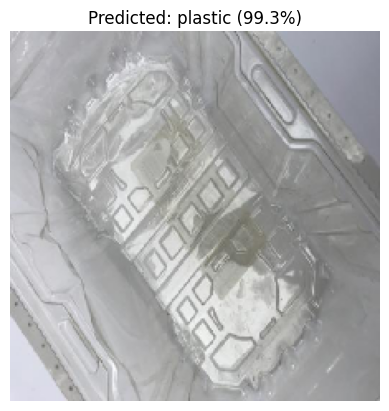

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from IPython import get_ipython

# Load previously stored variables
if get_ipython() is not None:
    get_ipython().run_line_magic('store', '-r test_path class_labels')

# --- CONFIGURATION ---
IMG_SIZE = 224
MODEL_SAVE_DIR = '/content/drive/MyDrive/Garbage_Model_Output'
MODEL_FILENAME = 'fine_tuned_mobilenet_model.h5'
checkpoint_filepath = os.path.join(MODEL_SAVE_DIR, MODEL_FILENAME)

# --- 1. Load Model and Preprocessor ---
print("--- 1. Loading Final Model ---")
try:
    final_model = load_model(checkpoint_filepath)
except Exception as e:
    print(f"Error loading model: {e}")
    raise

mobilenet_preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# --- 2. Select a Test Image ---
# To guarantee a test image exists, we will grab the first image found in the 'plastic' class directory.
test_class_dir = os.path.join(test_path, 'plastic') # You can change 'plastic' to any class name
test_images = [f for f in os.listdir(test_class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

if not test_images:
    raise FileNotFoundError(f"No images found in the test directory for class 'plastic' at {test_class_dir}")

# Use the first image found
img_path = os.path.join(test_class_dir, test_images[0])

print(f"\n--- 2. Testing Image: {img_path} ---")


# --- 3. Preprocess the Image ---
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)
# Expand dimensions to create a batch of size 1
img_array = np.expand_dims(img_array, axis=0)
# Apply the MobileNetV2 specific preprocessing
processed_img = mobilenet_preprocess_input(img_array)

# --- 4. Predict ---
print("--- 3. Running Prediction ---")
predictions = final_model.predict(processed_img)
predicted_class_index = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions) * 100

# --- 5. Display Result ---
predicted_class_name = class_labels[predicted_class_index]
true_class_name = os.path.basename(os.path.dirname(img_path))

print("\n--- ✅ Prediction Result ---")
print(f"Image True Class: **{true_class_name.capitalize()}**")
print(f"Model Prediction: **{predicted_class_name.capitalize()}**")
print(f"Confidence: **{confidence:.2f}%**")

# Optional: Display the image to verify
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name} ({confidence:.1f}%)")
plt.axis('off')
plt.show()

--- 1. Loading Final Model ---


Model loaded successfully.

--- 2. Please Upload Your Test Image ---


Saving Screenshot 2025-10-25 130752.png to Screenshot 2025-10-25 130752.png
File 'Screenshot 2025-10-25 130752.png' uploaded.

--- 3. Testing Image: Screenshot 2025-10-25 130752.png ---
--- 4. Running Prediction ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

--- ✅ Prediction Result ---
Model Prediction: **Plastic**
Confidence: **69.08%**


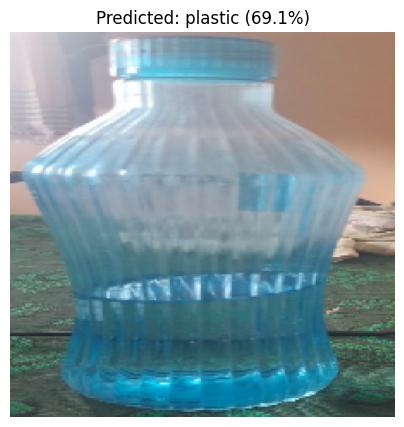

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython import get_ipython
from google.colab import files # Import the necessary Colab tool

# Load previously stored variables
if get_ipython() is not None:
    get_ipython().run_line_magic('store', '-r class_labels')

# --- CONFIGURATION ---
IMG_SIZE = 224
MODEL_SAVE_DIR = '/content/drive/MyDrive/Garbage_Model_Output'
MODEL_FILENAME = 'fine_tuned_mobilenet_model.h5'
checkpoint_filepath = os.path.join(MODEL_SAVE_DIR, MODEL_FILENAME)
mobilenet_preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# --- 1. Load Model ---
print("--- 1. Loading Final Model ---")
try:
    # Ensure the model is loaded before uploading the image
    final_model = load_model(checkpoint_filepath)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# --- 2. Upload Image and Get Path ---
print("\n--- 2. Please Upload Your Test Image ---")
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Skipping prediction.")
else:
    # Get the name of the first (and likely only) uploaded file
    YOUR_IMAGE_FILENAME = next(iter(uploaded))
    # Colab places uploaded files directly in the content directory
    YOUR_IMAGE_PATH = os.path.join('/content', YOUR_IMAGE_FILENAME)

    print(f"File '{YOUR_IMAGE_FILENAME}' uploaded.")
    print(f"\n--- 3. Testing Image: {YOUR_IMAGE_FILENAME} ---")

    # --- 4. Preprocess the Image ---
    img = image.load_img(YOUR_IMAGE_PATH, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    processed_img = mobilenet_preprocess_input(img_array)

    # --- 5. Predict ---
    print("--- 4. Running Prediction ---")
    predictions = final_model.predict(processed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions) * 100

    # --- 6. Display Result ---
    predicted_class_name = class_labels[predicted_class_index]

    print("\n--- ✅ Prediction Result ---")
    print(f"Model Prediction: **{predicted_class_name.capitalize()}**")
    print(f"Confidence: **{confidence:.2f}%**")

    # Display the image to verify
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name} ({confidence:.1f}%)")
    plt.axis('off')
    plt.show()